# DDPG for Financial Environment using TF-Agents
Reference: https://github.com/jeffheaton/t81_558_deep_learning/blob/569ed623cb225a5d410fda6f49e1a15073b247ea/t81_558_class_12_05_apply_rl.ipynb

In [1]:
# Bit of formatting because inline code is not styled very good by default:
from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
} </style>""")

In [2]:
# Get necessary libraries
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import math
import numpy as np

import tensorflow as tf

from tf_agents.agents.ddpg import actor_network
from tf_agents.agents.ddpg import critic_network
from tf_agents.agents.ddpg import ddpg_agent

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy, greedy_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.trajectories import policy_step
from tf_agents.utils import common

import gym
from gym import spaces
from gym.utils import seeding
from gym.envs.registration import register
import PIL.ImageDraw
import PIL.Image
from PIL import ImageFont
import pandas as pd

## Step 1: Create Environment
The environment simulates paying off a mortgage and saving for retirement. This simulation allows the agent to allocate their income between several types of account, buying luxury items, and paying off their mortgage. The goal is to maximize net worth. Because we wish to provide the agent with the ability to distribute their income among several accounts, we provide continuous (floating point) actions that determine this distribution of the agent's salary.

The environment class that you create must contain these elements:

- Be a child class of gym.Env
- Implement a seed function that sets a seed that governs the simulation's random aspects. For this environment, the seed oversees the random fluctuations in inflation and rates of return.
- Implement a reset function that resets the state for a new episode.
- Implement a render function that renders one frame of the simulation. The rendering is only for display and does not affect reinforcement learning.
- Implement a step function that performs one step of your simulation.

The class presented below implements a financial planning simulation. The agent must save for retirement and should attempt to amass the greatest possible net worth. The simulation includes the following key elements:

- Random starting salary between 40K (USD) and 60K (USD).
- Home loan for a house with a random purchase price that is between 1.5 and 4 times the starting salary.
- Home loan is a standard amortized 30-year loan with a fixed monthly payment.
- Paying higher than the home's monthly payment pays the loan down quicker. Paying below the monthly payment results in late fees and eventually foreclosure.
- Ability to allocate income between luxury purchases, home payments (above or below payment amount), as well as a taxable and tax-advantaged savings account.

The state is composed of the following floating point values:

- age - The agent's current age in months (steps)
- salary - The agent's starting salary, increases relative to inflation.
- home_value - The value of the agent's home, increases relative to inflation.
- home_loan - How much the agent still owes on their home.
- req_home_pmt - The minimum required home payment.
- acct_tax_adv - The balance of the tax advantaged retirement account.
- acct_tax - The balance of the taxable retuirement account.

The action space is composed of the following floating-point values (between 0 and 1):

- home_loan - The amount to apply to a home loan.
- savings_tax_adv - The amount to deposit in a tax-advantaged savings account.
- savings taxable - The amount to deposit in a taxable savings account.
- luxury - The amount to spend on luxury items/services.

In [3]:
class SimpleGameOfLifeEnv(gym.Env):
    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second': 1
    }

    STATE_ELEMENTS = 7
    STATES = ['age', 'salary', 'home_value', 'home_loan', 'req_home_pmt', 
              'acct_tax_adv', 'acct_tax', "expenses", "actual_home_pmt", "tax_deposit", 
              "tax_adv_deposit", "net_worth"]
    STATE_AGE = 0
    STATE_SALARY = 1
    STATE_HOME_VALUE = 2
    STATE_HOME_LOAN = 3
    STATE_HOME_REQ_PAYMENT = 4
    STATE_SAVE_TAX_ADV = 5
    STATE_SAVE_TAXABLE = 6

    MEG = 1.0e6

    ACTION_ELEMENTS = 4
    ACTION_HOME_LOAN = 0
    ACTION_SAVE_TAX_ADV = 1
    ACTION_SAVE_TAXABLE = 2
    ACTION_LUXURY = 3

    INFLATION = (0.015)/12.0
    INTEREST = (0.05)/12.0
    TAX_RATE = (.142)/12.0
    EXPENSES = 0.6
    INVEST_RETURN = 0.065/12.0
    SALARY_LOW = 40000.0
    SALARY_HIGH = 60000.0
    START_AGE = 18
    RETIRE_AGE = 80

    def __init__(self, goal_velocity=0):
      self.verbose = False
      self.viewer = None

      self.action_space = spaces.Box(
          low=0.0,
          high=1.0,
          shape=(SimpleGameOfLifeEnv.ACTION_ELEMENTS,),
          dtype=np.float32
      )
      self.observation_space = spaces.Box(
          low=0,
          high=2,
          shape=(SimpleGameOfLifeEnv.STATE_ELEMENTS,),
          dtype=np.float32
      )

      self.seed()
      self.reset()

      self.state_log = []

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def _calc_net_worth(self):
      home_value = self.state[SimpleGameOfLifeEnv.STATE_HOME_VALUE]
      principal = self.state[SimpleGameOfLifeEnv.STATE_HOME_LOAN]
      worth = home_value - principal
      worth += self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAX_ADV]
      worth += self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAXABLE]
      return worth

    def _eval_action(self, action, payment):
      # Calculate actions
      act_home_payment = action[SimpleGameOfLifeEnv.ACTION_HOME_LOAN]
      act_tax_adv_pay = action[SimpleGameOfLifeEnv.ACTION_SAVE_TAX_ADV]
      act_taxable = action[SimpleGameOfLifeEnv.ACTION_SAVE_TAXABLE]
      act_luxury = action[SimpleGameOfLifeEnv.ACTION_LUXURY]
      if payment <=0:
        act_home_payment = 0
      total_act = act_home_payment + act_tax_adv_pay + act_taxable + act_luxury + self.expenses

      if total_act <1e-2:
        pct_home_payment = 0
        pct_tax_adv_pay = 0
        pct_taxable = 0
        pct_luxury = 0
      else:
        pct_home_payment = act_home_payment / total_act
        pct_tax_adv_pay = act_tax_adv_pay / total_act
        pct_taxable = act_taxable / total_act
        pct_luxury = act_luxury / total_act

      return pct_home_payment, pct_tax_adv_pay, pct_taxable, pct_luxury

    def step(self, action):
      self.last_action = action
      age = self.state[SimpleGameOfLifeEnv.STATE_AGE]
      salary = self.state[SimpleGameOfLifeEnv.STATE_SALARY]
      home_value = self.state[SimpleGameOfLifeEnv.STATE_HOME_VALUE]
      principal = self.state[SimpleGameOfLifeEnv.STATE_HOME_LOAN]
      payment = self.state[SimpleGameOfLifeEnv.STATE_HOME_REQ_PAYMENT]
      net1 = self._calc_net_worth()
      remaining_salary = salary

      # Calculate actions
      pct_home_payment, pct_tax_adv_pay, pct_taxable, pct_luxury = \
        self._eval_action(action,payment)

      # Expenses
      current_expenses = salary * self.expenses
      remaining_salary -= current_expenses
      if self.verbose:
        print(f"Expenses: {current_expenses}")
        print(f"Remaining Salary: {remaining_salary}")

      # Tax advantaged deposit action
      my_tax_adv_deposit = min(salary * pct_tax_adv_pay, remaining_salary)
      my_tax_adv_deposit = min(my_tax_adv_deposit, \
        self.year_tax_adv_deposit_left) # Govt CAP
      self.year_tax_adv_deposit_left -= my_tax_adv_deposit
      remaining_salary -= my_tax_adv_deposit
      tax_adv_deposit = my_tax_adv_deposit * 1.05 # Company match
      self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAX_ADV] += \
        int(tax_adv_deposit)

      if self.verbose:
        print(f"IRA Deposit: {tax_adv_deposit}")
        print(f"Remaining Salary: {remaining_salary}")

      # Tax
      remaining_salary -= remaining_salary * SimpleGameOfLifeEnv.TAX_RATE
      if self.verbose:
        print(f"Tax Salary: {remaining_salary}")

      # Home payment
      actual_payment = min(salary * pct_home_payment, remaining_salary)

      if principal>0:
        ipart = principal * SimpleGameOfLifeEnv.INTEREST
        ppart = actual_payment - ipart
        principal = int(principal-ppart)
        if principal<=0:
          principal = 0
          self.state[SimpleGameOfLifeEnv.STATE_HOME_REQ_PAYMENT] = 0
        elif actual_payment < payment:
          self.late_count += 1
          if self.late_count>15:
            sell = (home_value-principal)/2
            sell -= 20000
            sell = max(sell,0)
            self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAXABLE] += sell
            principal = 0
            home_value = 0
            self.expenses += .3
            self.state[SimpleGameOfLifeEnv.STATE_HOME_REQ_PAYMENT] = 0
            if self.verbose:
              print(f"Foreclosure!!")
          else:
            late_fee = payment * 0.1
            principal += late_fee
            if self.verbose:
              print(f"Late Fee: {late_fee}")


        self.state[SimpleGameOfLifeEnv.STATE_HOME_LOAN] = principal
        remaining_salary -= actual_payment

      if self.verbose:
        print(f"Home Payment: {actual_payment}")
        print(f"Remaining Salary: {remaining_salary}")

      # Taxable savings
      actual_savings = remaining_salary * pct_taxable
      self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAXABLE] += actual_savings
      remaining_salary -= actual_savings

      if self.verbose:
        print(f"Tax Save: {actual_savings}")
        print(f"Remaining Salary (goes to Luxury): {remaining_salary}")

      # Investment income
      return_taxable = self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAXABLE] * \
          self.invest_return
      return_tax_adv = self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAX_ADV] * \
          self.invest_return

      return_taxable *= 1-SimpleGameOfLifeEnv.TAX_RATE
      self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAXABLE] += return_taxable
      self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAX_ADV] += return_tax_adv

      # Yearly events
      if age>0 and age % 12 == 0:
        self.perform_yearly()

      # Monthly events
      self.state[SimpleGameOfLifeEnv.STATE_AGE] += 1
      
      # Time to retire (by age?)
      done = self.state[SimpleGameOfLifeEnv.STATE_AGE] > \
        (SimpleGameOfLifeEnv.RETIRE_AGE*12)

      # Calculate reward 
      net2 = self._calc_net_worth()
      reward = net2 - net1

      # Track progress
      if self.verbose:
        print(f"Networth: {nw}")
        print(f"*** End Step {self.step_num}: State={self.state}, \
          Reward={reward}")
      self.state_log.append(self.state + [current_expenses, actual_payment, 
      actual_savings, my_tax_adv_deposit, net2])
      self.step_num += 1

      # Normalize state and finish up
      norm_state = [x/SimpleGameOfLifeEnv.MEG for x in self.state]
      return norm_state, reward/SimpleGameOfLifeEnv.MEG, done, {}

    def perform_yearly(self):
      salary = self.state[SimpleGameOfLifeEnv.STATE_SALARY]
      home_value = self.state[SimpleGameOfLifeEnv.STATE_HOME_VALUE]
      
      self.inflation = SimpleGameOfLifeEnv.INTEREST + \
          self.np_random.normal(loc=0,scale=1e-2)
      self.invest_return = SimpleGameOfLifeEnv.INVEST_RETURN + \
          self.np_random.normal(loc=0,scale=1e-2)

      self.year_tax_adv_deposit_left = 19000
      self.state[SimpleGameOfLifeEnv.STATE_SALARY] = \
        int(salary * (1+self.inflation))

      self.state[SimpleGameOfLifeEnv.STATE_HOME_VALUE] \
        = int(home_value * (1+self.inflation))

    def reset(self):
      self.expenses = SimpleGameOfLifeEnv.EXPENSES
      self.late_count = 0
      self.step_num = 0
      self.last_action = [0] * SimpleGameOfLifeEnv.ACTION_ELEMENTS
      self.state = [0] * SimpleGameOfLifeEnv.STATE_ELEMENTS
      self.state_log = []
      salary = float(self.np_random.randint(low=SimpleGameOfLifeEnv.SALARY_LOW,
                               high=SimpleGameOfLifeEnv.SALARY_HIGH))
      house_mult = self.np_random.uniform(low=1.5,high=4)
      value = round(salary*house_mult)
      p = (value*0.9)
      i = SimpleGameOfLifeEnv.INTEREST
      n = 30 * 12
      m = float(int(p *  ( i * (1 + i)**n ) / ( (1 + i)**n - 1)))
      self.state[SimpleGameOfLifeEnv.STATE_AGE] = \
        SimpleGameOfLifeEnv.START_AGE * 12
      self.state[SimpleGameOfLifeEnv.STATE_SALARY] = salary / 12.0
      self.state[SimpleGameOfLifeEnv.STATE_HOME_VALUE] = value
      self.state[SimpleGameOfLifeEnv.STATE_HOME_LOAN] = p
      self.state[SimpleGameOfLifeEnv.STATE_HOME_REQ_PAYMENT] = m
      self.year_tax_adv_deposit_left = 19000
      self.perform_yearly()
      return np.array(self.state)

    def render(self, mode='human'):
        screen_width = 600
        screen_height = 400

        img = PIL.Image.new('RGB', (600, 400))
        d = PIL.ImageDraw.Draw(img)
        font = ImageFont.load_default()
        y = 0
        _, height = d.textsize("W", font)
  
        age = self.state[SimpleGameOfLifeEnv.STATE_AGE]
        salary = self.state[SimpleGameOfLifeEnv.STATE_SALARY]*12
        home_value = self.state[SimpleGameOfLifeEnv.STATE_HOME_VALUE]
        home_loan = self.state[SimpleGameOfLifeEnv.STATE_HOME_LOAN]
        home_payment = self.state[SimpleGameOfLifeEnv.STATE_HOME_REQ_PAYMENT]
        balance_tax_adv = self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAX_ADV]
        balance_taxable = self.state[SimpleGameOfLifeEnv.STATE_SAVE_TAXABLE]
        net_worth = self._calc_net_worth()

        d.text((0, y), f"Age: {age/12}", fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Salary: {salary:,}", fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Home Value: {home_value:,}", fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Home Loan: {home_loan:,}", fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Home Payment: {home_payment:,}", fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Balance Tax Adv: {balance_tax_adv:,}", \
               fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Balance Taxable: {balance_taxable:,}", \
               fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Net Worth: {net_worth:,}", fill=(0, 255, 0))
        y+=height*2

        payment = self.state[SimpleGameOfLifeEnv.STATE_HOME_REQ_PAYMENT]
        pct_home_payment, pct_tax_adv_pay, pct_taxable, pct_luxury = \
          self._eval_action(self.last_action,payment)
        d.text((0, y), f"Percent Home Payment: {pct_home_payment}", \
               fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Percent Tax Adv: {pct_tax_adv_pay}", fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Percent Taxable: {pct_taxable}", fill=(0, 255, 0))
        y+=height
        d.text((0, y), f"Percent Luxury: {pct_luxury}", fill=(0, 255, 0))

        return np.array(img)

    def close(self):
        pass

You must register the environment class with TF-Agents before your program can use it.

In [4]:
register(id='simple-game-of-life-v0',
         entry_point=f'{__name__}:SimpleGameOfLifeEnv')

## Step 2: Test Environment

In [5]:
env_name = 'simple-game-of-life-v0'
env = gym.make(env_name)

env.reset()
done = False

i = 0
env.verbose = False
while not done:
    i += 1
    #if i>36: break
    # ACTION_HOME_LOAN = 0, ACTION_SAVE_TAX_ADV = 1, ACTION_SAVE_TAXABLE = 2
    # ACTION_LUXURY = 3
    state, reward, done, _ = env.step([1,1,0,0])
    env.render()
    
env.close()
print(env._calc_net_worth())

9218041.133155173


In [6]:
df = pd.DataFrame(env.state_log, columns=SimpleGameOfLifeEnv.STATES)
df = df.round(0)
df['age'] = df['age']/12
df['age'] = df['age'].round(2)
for col in df.columns:
  df[col] = df[col].apply(lambda x : "{:,}".format(x))

pd.set_option('display.max_columns', 7)
pd.set_option('display.max_rows', 12)
display(df)

age salary home_value  ... tax_deposit tax_adv_deposit    net_worth
0    18.08  4,726    156,689  ...         0.0         1,807.0     17,778.0
1    18.17  4,726    156,689  ...         0.0         1,818.0     19,129.0
2    18.25  4,726    156,689  ...         0.0         1,818.0     20,495.0
3    18.33  4,726    156,689  ...         0.0         1,818.0     21,875.0
4    18.42  4,726    156,689  ...         0.0         1,818.0     23,270.0
..     ...    ...        ...  ...         ...             ...          ...
740  79.75  6,611    220,357  ...         0.0           661.0  9,406,689.0
741  79.83  6,611    220,357  ...         0.0           661.0  9,359,197.0
742  79.92  6,611    220,357  ...         0.0           661.0  9,311,954.0
743   80.0  6,611    220,357  ...         0.0           661.0  9,264,959.0
744  80.08  6,605    220,188  ...         0.0           661.0  9,218,041.0

[745 rows x 12 columns]

## Step 3: Set Hyperparameters

In [7]:
num_iterations = 100000 
initial_collect_steps = 10000   
collect_steps_per_iteration = 1
replay_buffer_max_length = 1000000

batch_size = 64  
log_interval = 5000  
num_eval_episodes = 100
eval_interval = 10000

actor_fc_layers = (512, 256)
critic_joint_fc_layers = (256,)
critic_obs_fc_layers=(512,)
td_errors_loss_fn = tf.compat.v1.losses.mean_squared_error
gamma = 0.99

actor_learning_rate = 1e-4
critic_learning_rate = 1e-4

## Step 4: Instantiate Environment

In [8]:
env_name = 'simple-game-of-life-v0'
env = suite_gym.load(env_name)

env.reset()
PIL.Image.fromarray(env.render())

print("Action space: ", env.action_space)
print("Observation space: ", env.observation_space)

Action space:  Box(4,)
Observation space:  Box(7,)


In [9]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## Step 5: Define Network

In [10]:
global_step = tf.compat.v1.train.get_or_create_global_step()
observation_spec = train_env.time_step_spec().observation
action_spec = train_env.action_spec()

critic_net = critic_network.CriticNetwork(
    (observation_spec, action_spec),
    observation_fc_layer_params = critic_obs_fc_layers,
    action_fc_layer_params = None,
    joint_fc_layer_params = critic_joint_fc_layers)

actor_net = actor_network.ActorNetwork(
        observation_spec,
        action_spec,
        fc_layer_params=actor_fc_layers)

In [11]:
tf_agent = ddpg_agent.DdpgAgent(
    train_env.time_step_spec(),
    action_spec,
    actor_network = actor_net,
    critic_network = critic_net,
    actor_optimizer = tf.compat.v1.train.AdamOptimizer(
        learning_rate = actor_learning_rate),
    critic_optimizer = tf.compat.v1.train.AdamOptimizer(
        learning_rate = critic_learning_rate),
    td_errors_loss_fn = td_errors_loss_fn,
    gamma = gamma,
    train_step_counter = global_step)

tf_agent.initialize()

## Step 6: Policies
Agents contain two policies: the main policy (agent.policy) and the behavioral policy that is used for data collection (agent.collect_policy). For evaluation/deployment, we take the mean action by wrapping the main policy with GreedyPolicy().

In [12]:
eval_policy = greedy_policy.GreedyPolicy(tf_agent.policy)
collect_policy = tf_agent.collect_policy

random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

## Step 7: Metrics and Evaluation

In [13]:
def compute_avg_return(environment, policy, num_episodes=5):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

compute_avg_return(eval_env, eval_policy, num_eval_episodes)

13.515765

## Step 8: Replay Buffer

In [14]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

## Step 9: Data Collection

In [15]:
initial_collect_driver = dynamic_step_driver.DynamicStepDriver(
        train_env,
        collect_policy,
        observers=[replay_buffer.add_batch],
        num_steps=initial_collect_steps)
initial_collect_driver.run()

# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

iterator = iter(dataset)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


## Step 10: Train Agent

In [16]:
collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=collect_steps_per_iteration)

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
tf_agent.train = common.function(tf_agent.train)
collect_driver.run = common.function(collect_driver.run)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, eval_policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  collect_driver.run()

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = tf_agent.train(experience)

  step = tf_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, eval_policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

step = 5000: loss = 0.0014789324486628175
step = 10000: loss = 0.09817284345626831
step = 10000: Average Return = 11.990819931030273
step = 15000: loss = 3.04025936126709
step = 20000: loss = 2.907820701599121
step = 20000: Average Return = 12.464037895202637
step = 25000: loss = 5.99216365814209
step = 30000: loss = 17.18113136291504
step = 30000: Average Return = 13.369418144226074
step = 35000: loss = 0.23992794752120972
step = 40000: loss = 0.002521651331335306
step = 40000: Average Return = 12.4978666305542
step = 45000: loss = 0.14704158902168274
step = 50000: loss = 0.18362219631671906
step = 50000: Average Return = 14.445322036743164
step = 55000: loss = 0.0004708085907623172
step = 60000: loss = 0.001813960843719542
step = 60000: Average Return = 13.958907127380371
step = 65000: loss = 0.30375051498413086
step = 70000: loss = 0.001214670017361641
step = 70000: Average Return = 13.487055778503418
step = 75000: loss = 0.0015607078094035387
step = 80000: loss = 0.0004034526646137

## Step 11: Visualize

(11.86809482574463, 14.568047142028808)

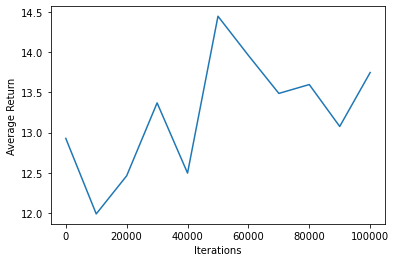

In [17]:
steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim()

In [18]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

def create_policy_eval_video(policy, filename, num_episodes=3, fps=60):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)


create_policy_eval_video(tf_agent.policy, "ddpg-trained")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [19]:
create_policy_eval_video(random_policy, "ddpg-random")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
